# VLA Outlog Analysis

This notebook was built to take output log text files for the VLA and use python to interrogate the records. The primary objective is to help inform SETI observation plans. 

#### Section 1: Loading
To begin, I imported the necessary packages, a few custom functions, loaded the data files and parsed out the relevant text strings from each line of each file. 

#### Section 2: Tabulating and Filtering
I then built a dataframe table containing the relevant information on each observation. 

#### Section 3: Probing the Data
With the pandas DataFrame constructed this is where I begin to probe the data. Scroll down to this section for the bottom line.

#### Section 4: Plotting
Everyone appreciates visual representations of the data. In this section I put together a few plots to display the information.

## Section 1: Loading

In [26]:
import os
import glob
import time
import pandas as pd
import numpy as np
from math import trunc
from datetime import datetime
from datetime import date
from datetime import timedelta
from astropy.time import Time
import astropy.units as u
import astropy.coordinates as coord
import ephem
import random

This next line finds the text files. Note that this assumes all the text files are within the same folder as the jupyter notebook. <br>If you are using this notebook, you will need to change the directory to reflect the path where the output logs are stored.

In [2]:
os.chdir('C:\\Users\\sirsp\\Jupyter_Notebook\\VLA')
outlogs=sorted(glob.glob('vla_output_*.dat'))

This next cell contains some custom functions for moving between a datetime object and the date/time strings as formatted in the text files. Some are hold overs from another project and are not necessarily used here.

In [3]:
# date and time string to a datetime object
def timestr_to_datetime(duration):
    return datetime.strptime(duration,'%H:%M:%S.%f')

def datetime_to_timestr(duration):
    return duration.strftime('%H:%M:%S.%f')

def dtdate_to_datestr(duration):
    return duration.strftime('%Y-%m-%d')

def dtstr_to_datetime(date_and_time):
    return datetime.strptime(date_and_time,'%Y-%m-%d %H:%M:%S.%f')

def datestr_to_datetime(date):
    return datetime.strptime(date,'%Y-%m-%d')

def timestr_to_secs(item):
    secs = float(item.split(':')[0])*3600+float(item.split(':')[1])*60+float(item.split(':')[2].replace(',','.'))
    return secs

def datetime_to_secs(item):
    return timestr_to_secs(datetime_to_timestr(item))

def secs_to_timestr(secs):
    h = trunc(secs/3600)
    m = trunc(secs/60-60*h)
    s = secs-3600*h-60*m
    return '%02d:%02d:%.6f' % (h, m, s)

This next cell is the main loop that harvests the log files for the relevant text strings. Here is a sample text block from the outlog file:

PROJID= 38678178 SRC= ZTF21aaocrlm_2 (ra,dec)=( 122.730 , -6.047 ) deg | MJD= 59302.978253 - 59302.978945 | NANT= 27  6GHz [4488.0, 5488.0]

The loop reads each line of the file and records the following from the block: 

Project ID
Source name
RA (in degrees)
Dec (in degrees)
Start date and time in MJD
End date and time in MJD
Number of antennas
Reciever frequency
Channel frequencies

In [4]:
PROJID=[]
SRC=[]
RA=[]
DEC=[]
MJD_Start=[]
MJD_End=[]
NANT=[]
date_start=[]
time_start=[]
date_end=[]
time_end=[]
Receiver=[]
Channels=[]

for log in outlogs:
    dat = open(log,'r').readlines()
    for line in dat:
        PROJID.append(line.split('PROJID= ')[1].split(' ')[0])
        SRC.append(line.split('SRC= ')[1].split(' ')[0])
        RA.append(line.split('(ra,dec)=( ')[1].split(' ')[0])                    # degrees
        DEC.append(line.split('(ra,dec)=( ')[1].split(' , ')[1].split(' ')[0])   # degrees
        MJD_Start.append(line.split('MJD= ')[1].split(' ')[0])
        MJD_End.append(line.split('MJD= ')[1].split(' - ')[1].split(' ')[0])
        NANT.append(line.split('NANT= ')[1].split(' ')[0])
        if line.split('NANT= ')[1].split(' ')[-1]:
            Receiver.append(line.split('NANT= ')[1].split(' ')[2])
            Channels.append(line.split('[')[1].split(']')[0])
        else:
            Receiver.append('None')
            Channels.append('None')
    print(f'Number of Scans in {log}: ',len(dat))
dt_start = Time(MJD_Start,format='mjd').to_value('datetime')
dt_end = Time(MJD_End,format='mjd').to_value('datetime')
for date in Time(MJD_Start,format='mjd').to_value('iso'):
    date_start.append(date.split(' ')[0])
    time_start.append(date.split(' ')[1])
for date in Time(MJD_End,format='mjd').to_value('iso'):
    date_end.append(date.split(' ')[0])
    time_end.append(date.split(' ')[1])

Number of Scans in vla_output_20210401.dat:  2479


The above loop prints out the length of the dat file, showing how many lines, and thus how many scans, are recorded in the file.<br>

Below is another sample line for a scan in the output.

In [5]:
dat[1000]

'PROJID= Unknown SRC= 3C84 (ra,dec)=( 49.951 , 41.512 ) deg | MJD= 59303.875961 - 59303.876192 | NANT= 27  10GHz [8888.0, 8916.0]\n'

## Section 2: Tabulating and Filtering

For convenient data manipulation, the following cell concatenates the arrays made of the strings into a single pandas DataFrame. For convenient visualization and manipulation later on, additional columns are appended with the time of each scan in modified format. The first 6 rows are then printed for visual inspection. I chose 6 arbitrarily just to get a small sample size with some diversity in the source.

In [6]:
a = PROJID
b = SRC
c = RA
d = DEC
e = MJD_Start
f = MJD_End
g = NANT
h = Receiver
i = Channels
j = date_start
k = time_start
l = date_end
m = time_end
n = dt_start
o = dt_end
Data_set = np.c_[a,b,c,d,e,f,g,h,i,j,k,l,m,n,o]
df = pd.DataFrame(np.column_stack([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o]), 
                  columns=['PROJID', 'SRC', 'RA','DEC','MJD_Start','MJD_End','NANT', 'Receiver','Channels',
                           'Start_Date','Start_Time','End_Date','End_Time','Datetime_Start','Datetime_End'])
df['RA']=df['RA'].astype(float)
df['DEC']=df['DEC'].astype(float)
df['MJD_Start']=df['MJD_Start'].astype(float)
df['MJD_End']=df['MJD_End'].astype(float)
df['NANT']=df['NANT'].astype(int)
df['Obs_Secs']=[(df.Datetime_End[x] - df.Datetime_Start[x]).total_seconds() for x in range(len(df))]
df[0:6]

,PROJID,SRC,RA,DEC,MJD_Start,MJD_End,NANT,Receiver,Channels,Start_Date,Start_Time,End_Date,End_Time,Datetime_Start,Datetime_End,Obs_Secs
0,38678178,ZTF21aaocrlm_2,122.73,-6.047,59302.978253,59302.978945,27,6GHz,"4488.0, 5488.0",2021-03-29,23:28:41.059,2021-03-29,23:29:40.848,2021-03-29 23:28:41.059200,2021-03-29 23:29:40.848000,59.7888
1,38678178,ZTF21aaocrlm_2,122.73,-6.047,59302.978945,59302.979638,27,6GHz,"4488.0, 5488.0",2021-03-29,23:29:40.848,2021-03-29,23:30:40.723,2021-03-29 23:29:40.848000,2021-03-29 23:30:40.723200,59.8752
2,38678178,ZTF21aaocrlm_2,122.73,-6.047,59302.979638,59302.980330,27,6GHz,"4488.0, 5488.0",2021-03-29,23:30:40.723,2021-03-29,23:31:40.512,2021-03-29 23:30:40.723200,2021-03-29 23:31:40.512000,59.7888
3,38678178,ZTF21aaocrlm_2,122.73,-6.047,59302.981023,59302.981715,27,6GHz,"4488.0, 5488.0",2021-03-29,23:32:40.387,2021-03-29,23:33:40.176,2021-03-29 23:32:40.387200,2021-03-29 23:33:40.176000,59.7888
4,38678178,ZTF21aaocrlm_2,122.73,-6.047,59302.981715,59302.982408,27,6GHz,"4488.0, 5488.0",2021-03-29,23:33:40.176,2021-03-29,23:34:40.051,2021-03-29 23:33:40.176000,2021-03-29 23:34:40.051200,59.8752
5,38678178,J0744-0629,116.09,-6.493,59302.982408,59302.983377,27,6GHz,"4488.0, 5488.0",2021-03-29,23:34:40.051,2021-03-29,23:36:03.773,2021-03-29 23:34:40.051200,2021-03-29 23:36:03.772800,83.7216


## Section 3: Probing the Data

This is where we get to the numbers that matter. This next cell has self-explanatory output. 

The "Ideal" scan duration was arbitrarily chosen based on the ostensible BL goal of 5 minutes minimum of observation per target. This can be adjusted with input from senior project scientists.

In [7]:
# Set observation duration benchmark for long/short scans
Ideal = 5 # minutes

# Totals

Total_Observation_Time = df['Obs_Secs'].sum()
Ave_Obs_Dur = df['Obs_Secs'].sum()/len(df)
Total_Log_Time = (df.Datetime_End[len(df)-1] - df.Datetime_Start[0]).total_seconds()
Total_Uptime = Total_Observation_Time / Total_Log_Time
Num_Short_Obs = df.loc[df['Obs_Secs'] < Ideal*60].count()[0]
Num_Long_Obs = df.loc[df['Obs_Secs'] > Ideal*60].count()[0]
Ave_Num_Obs = len(df)/(Total_Log_Time/86400)
Ave_Obs_Hours = Ave_Num_Obs * Ave_Obs_Dur/3600
Max_Dur = df['Obs_Secs'].max()
Min_Dur = df['Obs_Secs'].min()
Ave_Ants = df['NANT'].sum()/len(df)
Max_Ants = df['NANT'].max()
Min_Ants = df['NANT'].min()
X=30
LessThanXSec = len(df[df['Obs_Secs'] <X]['Obs_Secs'])
print(f'Total Number of Scans: \t\t\t\t{len(df)}')
print(f'Average Scans per Day: \t\t\t\t{Ave_Num_Obs:.1f}')
print(f'Average Scans per Hour: \t\t\t{Ave_Num_Obs/24:.1f}')
print(f'Average Scans Hours per Day: \t\t\t{Ave_Obs_Hours:.2f} hours.')
print(f'\nNumber of Scans Less Than {Ideal} minutes: \t\t{Num_Short_Obs} = {Num_Short_Obs/len(df)*100:.2f}%')
print(f'Number of Scans Longer Than {Ideal} minutes: \t\t{Num_Long_Obs} = {Num_Long_Obs/len(df)*100:.2f}%')
print(f'\nAverage Scans Duration: \t\t\t{Ave_Obs_Dur:.2f} seconds = {Ave_Obs_Dur/60:.2f} minutes = {Ave_Obs_Dur/3600:.2f} hours.')
print(f'Longest Scans Duration: \t\t\t{Max_Dur:.2f} seconds = {Max_Dur/60:.2f} minutes = {Max_Dur/3600:.2f} hours.')
print(f'Shortest Scans Duration: \t\t\t{Min_Dur} seconds.')
print(f'\t\t\t\t\t\t[There were {LessThanXSec} "Scans" Less Than {X} seconds.]')
print(f'\nAverage Number of Antennas In Use: \t\t{Ave_Ants:.0f} antennas.')
print(f'Maximum Number of Antennas In Use: \t\t{Max_Ants:.0f} antennas.')
print(f'Minimum Number of Antennas In Use: \t\t{Min_Ants:.0f} antennas.')
print(f'\nTotal Observation Time: \t\t\t{Total_Observation_Time:.2f} seconds', 
      f'= {Total_Observation_Time/3600:.2f} hours = {Total_Observation_Time/86400:.2f} days.')
print(f'Total Operational Time: \t\t\t{Total_Log_Time:.2f} seconds', 
      f'= {Total_Log_Time/3600:.2f} hours = {Total_Log_Time/86400:.2f} days.')
print(f'\nTotal Uptime: \t\t\t\t\t{Total_Uptime*100:.2f}%')

Total Number of Scans: 				2479
Average Scans per Day: 				961.1
Average Scans per Hour: 			40.0
Average Scans Hours per Day: 			18.88 hours.

Number of Scans Less Than 5 minutes: 		2416 = 97.46%
Number of Scans Longer Than 5 minutes: 		63 = 2.54%

Average Scans Duration: 			70.71 seconds = 1.18 minutes = 0.02 hours.
Longest Scans Duration: 			738.03 seconds = 12.30 minutes = 0.21 hours.
Shortest Scans Duration: 			1.9872 seconds.
						[There were 1168 "Scans" Less Than 30 seconds.]

Average Number of Antennas In Use: 		27 antennas.
Maximum Number of Antennas In Use: 		27 antennas.
Minimum Number of Antennas In Use: 		9 antennas.

Total Observation Time: 			175293.33 seconds = 48.69 hours = 2.03 days.
Total Operational Time: 			222857.65 seconds = 61.90 hours = 2.58 days.

Total Uptime: 					78.66%


The next cell probes the bracketed channels at the end of each input line. The output is self-explanatory.

In [8]:
ch2=0
ch3=0
ch4=0
unknown=0
Non=0
for c in df.Channels:
    if len(c.split(','))==2:
        ch2+=1
    elif len(c.split(','))==3:
        ch3+=1
    elif len(c.split(','))==4:
        ch4+=1
    elif c=='None':
        Non+=1
    else:
        unknown+=1
Tot_ch = ch2+ch4+unknown
print('Total number of scans: \t\t\t\t',Tot_ch,'\n')
print('Number of scans using 2 channels: \t\t',ch2,f'= {ch2/Tot_ch*100:.2f}%')
print('Number of scans using 4 channels: \t\t',ch4,f'= {ch4/Tot_ch*100:.2f}%')
print('\nNumber of scans using 3 channels: \t\t',ch3,f'= {ch3/Tot_ch*100:.2f}%')
print('Number of scans using None: \t\t\t',Non,f'= {Non/Tot_ch*100:.2f}%')
print('Number of scans using unknown channels: \t',unknown)

Total number of scans: 				 2436 

Number of scans using 2 channels: 		 1898 = 77.91%
Number of scans using 4 channels: 		 538 = 22.09%

Number of scans using 3 channels: 		 42 = 1.72%
Number of scans using None: 			 1 = 0.04%
Number of scans using unknown channels: 	 0


The next two cells list the unique project IDs and source names, respectively. 

In [9]:
print('Number of unique project IDs: ', len(sorted(set(df.PROJID))))
print('\nProject ID list:\n',sorted(set(df.PROJID)))

Number of unique project IDs:  24

Project ID list:
 ['1346618', '1378178', '2285406', '28850329', '37594215', '38678178', '38678198', '39298250', '39306874', '39307021', '39307074', '39307204', '39307349', '39307670', '39307764', '39308327', '39308369', '39308448', '39308539', '39308595', '39333191', '39530385', '4538748', 'Unknown']


In [10]:
print('Number of unique source names: ', len(sorted(set(df.SRC))))
print('\nSource list:\n',sorted(set(df.SRC)))

Number of unique source names:  101

Source list:
 ['0137+331=3C48', '1153+8058', '1331+305=3C286', '1339+2955BF', '3C147', '3C273', '3C286', '3C345', '3C48', '3C84', '4C+63.22', 'AzElSource', 'G31p41pol', 'HOLORASTER', 'Holmberg', 'IRAS', 'J0112+2244', 'J0319+4130', 'J0431+2037', 'J0438+3004', 'J0542+4951', 'J0604+4413', 'J0607+4739', 'J0713+4349', 'J0744-0629', 'J0745+1011', 'J0841+7053', 'J0854+2006', 'J0949+6614', 'J1206+3941', 'J1310+3220', 'J1329+3154', 'J1330+2509', 'J1331+3030', 'J1400+6210', 'J1407+2827', 'J1417+4607', 'J1419+5423', 'J1436+6336', 'J1438+6211', 'J1613+3412', 'J1624+5741', 'J1638+5720', 'J1642+6856', 'J1700-2610', 'J1733-1304', 'J1740+5211', 'J1743-0350', 'J1800+7828', 'J1820-2528', 'J1832-1035', 'J1851+0035', 'J1911-2006', 'J1927+6117', 'J2115+2933', 'J2131-1207', 'J2253+1608', 'J2355+4950', 'J2357-1125', 'MCG+08-11-11', 'Maximum', 'NGC4869', 'NGC5204', 'PTF12dam', 'S2CDFN002.0', 'S2EGS002.0', 'SDC13-N_11', 'SGRB210323A', 'SN', 'SN2017hcc', 'TMC-1', 'Z21aafnunh

## Section 4: Plotting

In this section I put together some plots:

A bar plot showing the scans each day.<br>
Histograms of the scans/observations for each source.<br>
The observation targets on the sky.<br>

### Plot 1: Daily Uptime Bar Plot

My first attempt at plotting the scans is similar to what I had done with the MeerKAT outlogs. It is just a stacked bar plot to count the total time in a day that the array was operational. It is arbitrarily and automatically colored by each individual scan output. It is most useful in giving a quick visualization of the total uptime of the array on a given day.

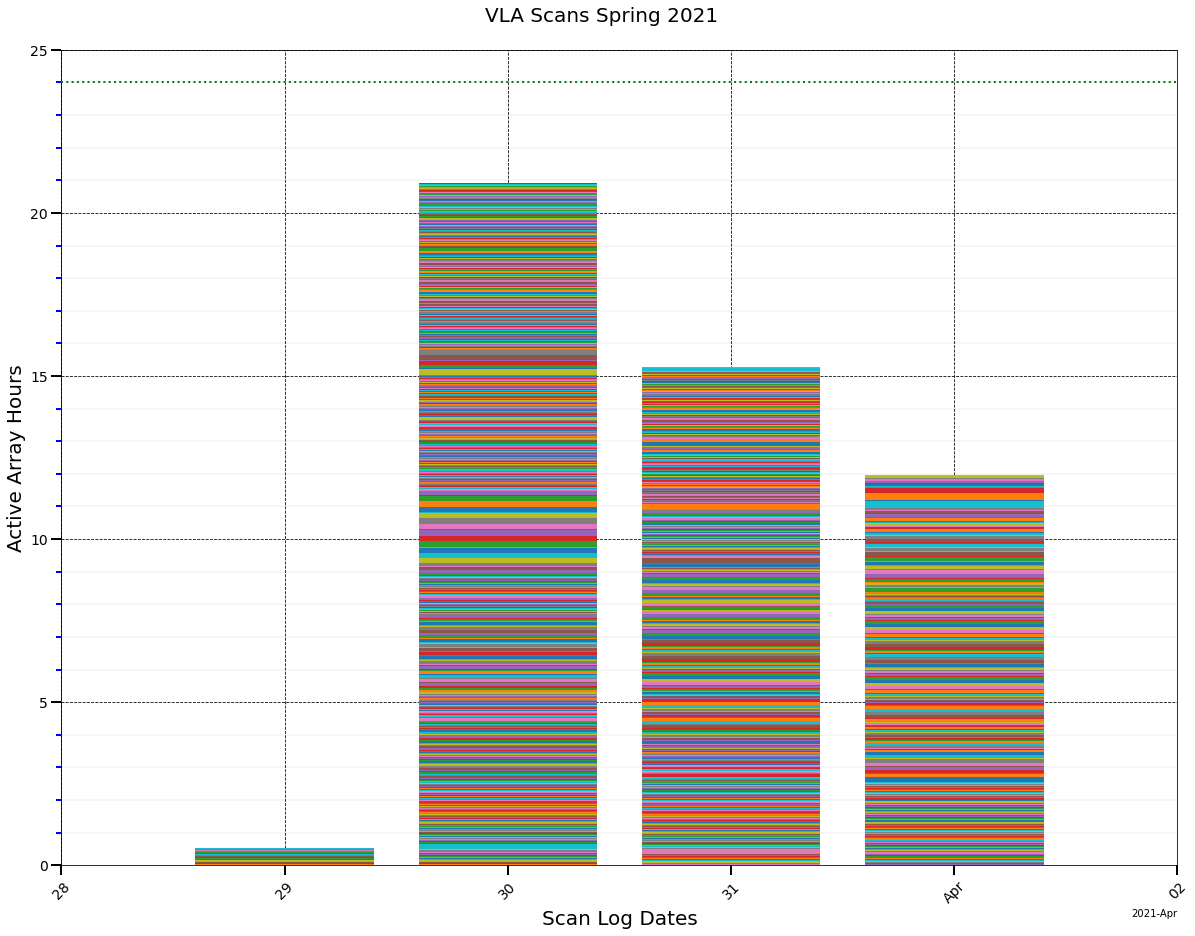

In [11]:
# Plot the number of observations taken each day over the log period.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(20,15))

# Set data to be plotted
Dates=[]
for row in df.itertuples():
    Dates.append(pd.to_datetime(row.Start_Date).date())   # Get the dates in a plot-friendly format
Dates = sorted(list(set(Dates)))
Upbydate = df.groupby('Start_Date').sum()['Obs_Secs'].divide(3600) # Total time of observations per day in seconds
num_obs = df['Start_Date'].value_counts().sort_index()
ave_ant_per_day = df.groupby('Start_Date').sum()['NANT']/num_obs

# Set colormapping
# interval = 4
# ants = np.arange(int(min(ave_ant_per_day)),int(max(ave_ant_per_day))+interval,interval)
# cmap = plt.cm.RdYlGn
# norm = matplotlib.colors.Normalize(vmin=min(ants), vmax=max(ants))
# colors=cmap(norm(ave_ant_per_day))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# cbar=fig.colorbar(sm,pad=0.01)
# cbar.set_ticks(ants)
# cbar.set_ticklabels(ants)
# cbar.ax.set_title('Antennas',y=-0.04)

# Make the bar plot, overlaid with max hours and average observation hours lines
for date in sorted(set(Dates)):
    bottom=0
    for y,secs in enumerate(df[[df.Datetime_Start[x].date()==date for x in range(len(df))]].Obs_Secs.divide(3600)):
        plt.bar(date,secs,bottom=bottom,zorder=20)
        bottom=bottom+secs
#     plt.bar(Dates, Upbydate,zorder=2,edgecolor='black',color=colors,label='Total Observation Hours per Day',alpha=0.8)
plt.hlines(y=24,xmin=Dates[0] - timedelta(days=1),zorder=3,xmax=Dates[-1] + timedelta(days=1),
           color='green',linestyle='dotted',linewidth=2,label='24 hours')
# plt.hlines(y=Ave_Obs_Hours,zorder=4,xmin=18531,xmax=18692,color='purple',linestyle='dashed',linewidth=1,label='Total Average Uptime')
# plt.scatter(Dates,Monthly_Uptime,zorder=5,marker='_',color='red',linewidth=3,label='Monthly Average Uptime')


# matplotlib date plotting axis stuff
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))
locator = mdates.AutoDateLocator(minticks=1, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
days = mdates.DayLocator()
ax.xaxis.set_minor_locator(days)

# make it pretty
plt.xticks(rotation='45',size=14)
plt.yticks(size=14)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=5, color='blue')
plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=5)
plt.grid(axis='y', which='minor', color='black', linewidth=0.1,linestyle='--',zorder=4)
ax.set_xlim(Dates[0] - timedelta(days=1),Dates[-1] + timedelta(days=1))
ax.set_ylim(0,25)

# set axis labels and title
plt.xlabel('Scan Log Dates', fontsize=20)
plt.ylabel('Active Array Hours', fontsize=20)
fig.suptitle('VLA Scans Spring 2021', fontsize=20, y=0.92)
# legend=plt.legend(prop={'size':20})
# legend.get_frame().set_linewidth(3)
# legend.get_frame().set_edgecolor('black')
# legend.get_frame().set_alpha(1)
plt.show()

### Plot 2a: Histograms of Duration

The next plot is a histogram of the scans, binned by duration. This gives a sense for the number of scans less/greater than a certain length of time. Each scan of the VLA is typically less than 5 minutes and rarely longer than 10 minutes, though the total observation time for each source is often longer than this through multiple scans of each source.

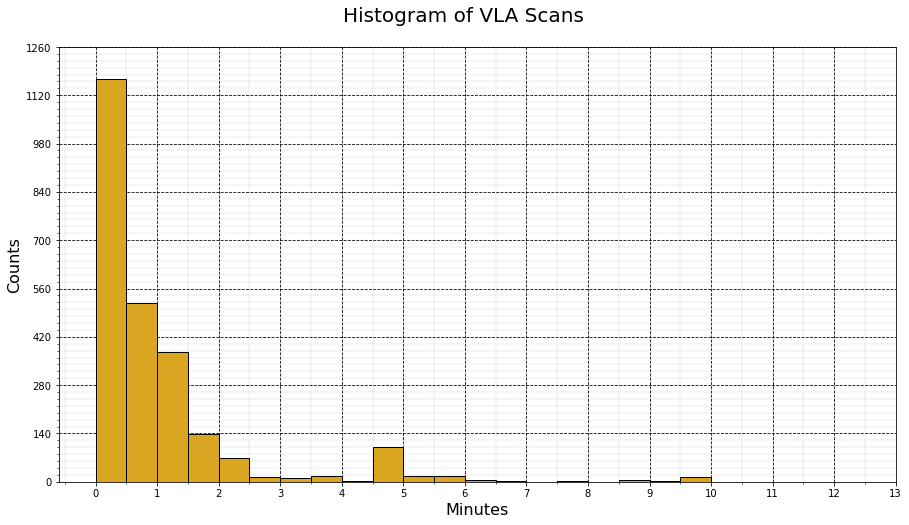

In [12]:
import matplotlib
from matplotlib import dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(15,8))

data=df.Obs_Secs/60
binwidth = 0.5        # minute
bins=np.arange(round(min(data)), round(max(data)) + binwidth, binwidth)

plt.hist(data,edgecolor='black',color='goldenrod',bins=bins,zorder=20)
plt.xticks(np.arange(0,max(data)+1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ymax = int(max(ax.get_yticks()))
plt.yticks(np.arange(0,ymax,ymax/10))
ax.yaxis.set_minor_locator(MultipleLocator(20))
plt.xlabel('Minutes',size=16)
plt.ylabel('Counts',size=16)
plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=5)
plt.grid(axis='both', which='minor', color='black', linewidth=0.1,linestyle='--',zorder=4)
fig.suptitle('Histogram of VLA Scans', fontsize=20, y=0.95)
plt.show()

### Plot 2b: Histograms of Duration

This second histogram combines the total observation time for each source and counts the number of sources that were observed for a total number of minutes within each 5 minute bin. 

This shows that while many observations do last for a total duration under 5 minutes, there are still many targets whose total observation time exceeds 5 minutes.

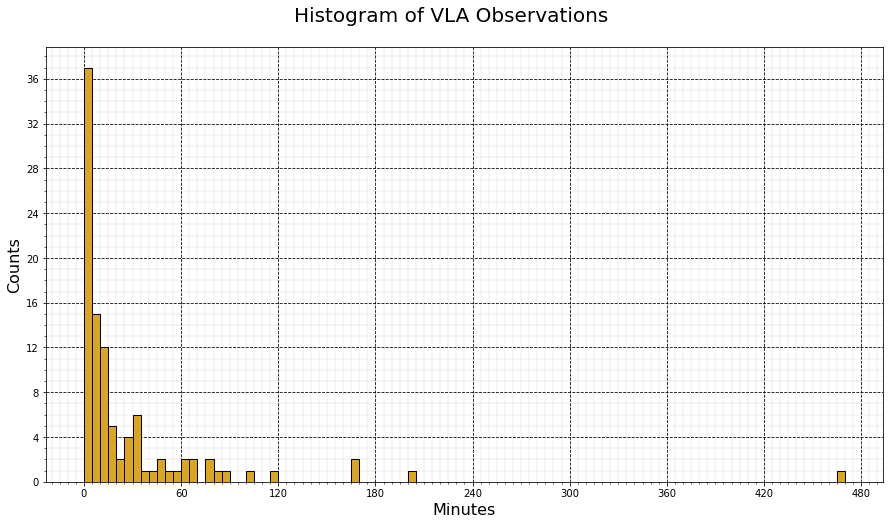

In [13]:
import matplotlib
from matplotlib import dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(15,8))

data=df.groupby('SRC')['Obs_Secs'].sum()/60
binwidth = 5        # minute
bins=np.arange(0, round(max(data)) + binwidth, binwidth)

plt.hist(data,edgecolor='black',color='goldenrod',zorder=20,bins=bins)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(60))
ymax = int(max(ax.get_yticks()))
plt.yticks(np.arange(0,ymax,ymax/10))
ax.yaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Minutes',size=16)
plt.ylabel('Counts',size=16)
plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=5)
plt.grid(axis='both', which='minor', color='black', linewidth=0.1,linestyle='--',zorder=4)
fig.suptitle('Histogram of VLA Observations', fontsize=20, y=0.95)
plt.show()

### Plot 3: Uptime by Clock Hour

This next plot is a better representation of the output data. This shows how the scans were conducted throughout the day. Note that while scans typically last less than 5 minutes and rarely over 10, multiple scans are conducted for each source throughout the day (sometimes one right after another), adding to the total observation time for each source.

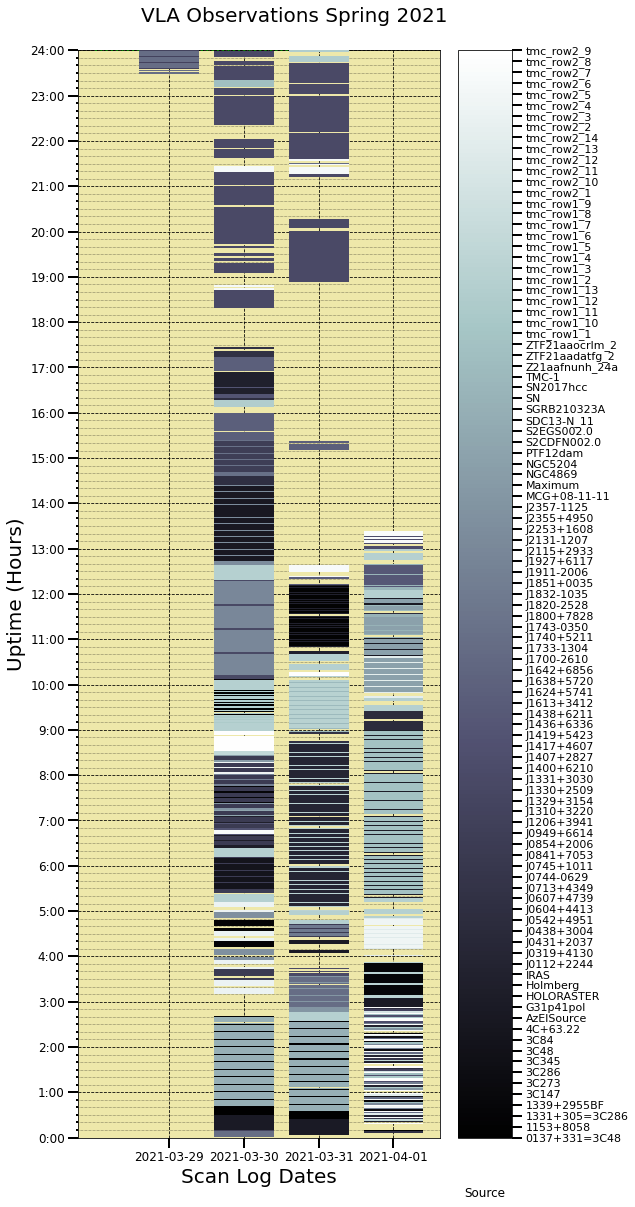

In [14]:
import matplotlib
from matplotlib import dates as mdates
from matplotlib.ticker import MultipleLocator
fig,ax = plt.subplots(figsize=(8,20))

m = len(sorted(set(df.SRC)))
SRC = np.arange(0,m,1)
cmap = plt.cm.bone
norm = matplotlib.colors.Normalize(vmin=0, vmax=m-1)
# color=cmap(norm(np.linspace(0,1,len(df))))
colors = [float(hash(s) % 256) / 256 for s in df.SRC] 
color = cmap([colors[x] for x in range(len(colors))])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar=fig.colorbar(sm,pad=0.04)
cbar.set_ticks(SRC)
cbar.set_ticklabels(sorted(set(df.SRC)))
cbar.ax.set_title('Source',y=-0.06)
cbar.ax.tick_params(labelsize=11, width=2,length=10)

for i in range(len(df)):
    Delta = (df.Datetime_End[i] - df.Datetime_Start[i]).seconds
    plt.bar(df.Start_Date[i],Delta/3600,bottom=timestr_to_secs(df.Start_Time[i])/3600,color=color[i],
            zorder=10)
plt.hlines(y=24,xmin=-1,zorder=3,xmax=2,color='green',linestyle='dotted',linewidth=2,label='24 hours')
# ax.set_xlim(-0.5,1.5)
plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=2)
plt.grid(axis='y', which='minor', color='black', linestyle='dotted',linewidth=0.5,zorder=1)

l=np.arange(0,25)
y=[str(hr)+':00' for hr in l]
# Set the tick positions
ax.set_yticks(l)
# Set the tick labels
ax.set_yticklabels(y)
ax.set_ylim(0,24)

ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1/6))
plt.xticks(size=12)
plt.yticks(size=12)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.set_facecolor('palegoldenrod')
plt.xlabel('Scan Log Dates', fontsize=20)
plt.ylabel('Uptime (Hours)', fontsize=20)
fig.suptitle('VLA Observations Spring 2021', fontsize=20, y=0.91)
plt.show()

### Plot 4a: Targets on Sky by Date

Since RA and Dec were also included in the data, I decided to add a plot to map all the observations on the sky. The markers are sized by total duration of scans for each source. The color indicates the day of the observation.

The snaking smudged band in the middle of the plot is the plane of the Milky Way for reference.

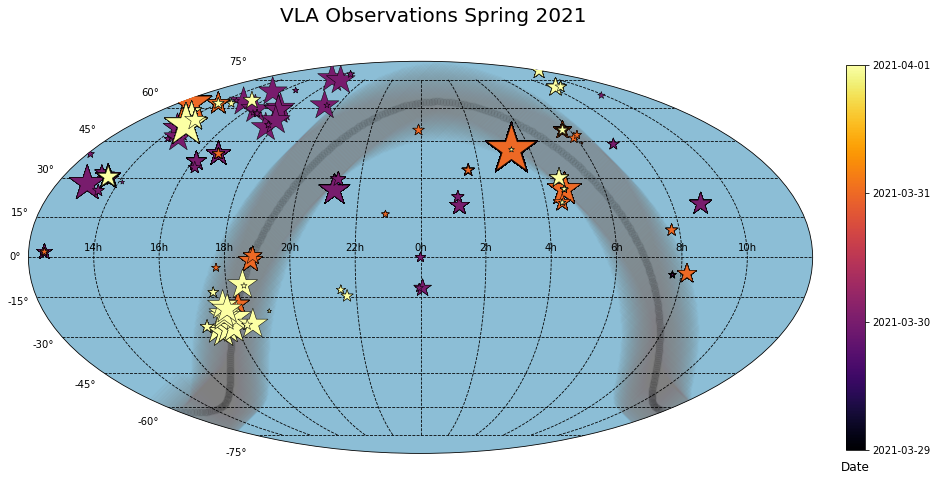

In [16]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection="mollweide")

Dates = sorted(set(df.Start_Date))

# This block generates the Milky Way band. Unused components are commented out.
lon_array = np.arange(-180,180)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA = coord.Angle((eq_array[:,0]+random.random()-0.5-180)*u.degree)
Dec = coord.Angle((random.random()-0.5-eq_array[:,1])*u.degree)
# Dust = [random.randint(1,10000) for _ in range(len(RA))]
# cmap=plt.cm.gray
# norm = matplotlib.colors.Normalize(vmin=min(Dust),vmax=max(Dust))
ax.scatter(RA.radian,Dec.radian, zorder=0.7,s=50,color='black',alpha=0.05)
ax.scatter(RA.radian,Dec.radian, zorder=0.5,s=3000,color='gray',alpha=0.05,marker='D')
# noise = np.random.random(360) * .1 + .3
# plt.fill_between(RA.radian, Dec.radian - noise, Dec.radian + noise, alpha = .3,color=cmap(norm(Dust)))

for d,date in enumerate(Dates):
    df_temp = df[df.Start_Date==date]
    cmap=plt.cm.inferno
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(Dates))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    colors=cmap(norm(np.linspace(0,len(Dates),len(Dates))))
    ra = coord.Angle(df[df['Start_Date'].str.contains(date)]['RA']*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(df[df['Start_Date'].str.contains(date)]['DEC']*u.degree)
    targets = df[df['Start_Date'].str.contains(date)]['SRC']
    sizes = df_temp.groupby('SRC')['Obs_Secs'].transform('sum')/5
    ax.scatter(ra.radian, dec.radian,s=sizes,marker='*',edgecolor='black',linewidth=0.5,color=colors[d],zorder=10)
    
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])

cbar=fig.colorbar(sm,pad=0.04,fraction=0.023)
cbar.set_ticks(np.linspace(0,len(Dates),len(Dates)))
cbar.set_ticklabels(sorted(set(Dates)))
cbar.ax.set_title('Date',y=-0.07)

plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=1)
ax.set_facecolor('#8CBED6')
fig.suptitle('VLA Observations Spring 2021', fontsize=20, y=0.85)
plt.show()

To make it easier to see observations on separate days I made the above plot for each day in a for loop. This is intended to remove the confusion of overlapping targets on different days and make it easier to see where on the sky the array was pointed for each day.

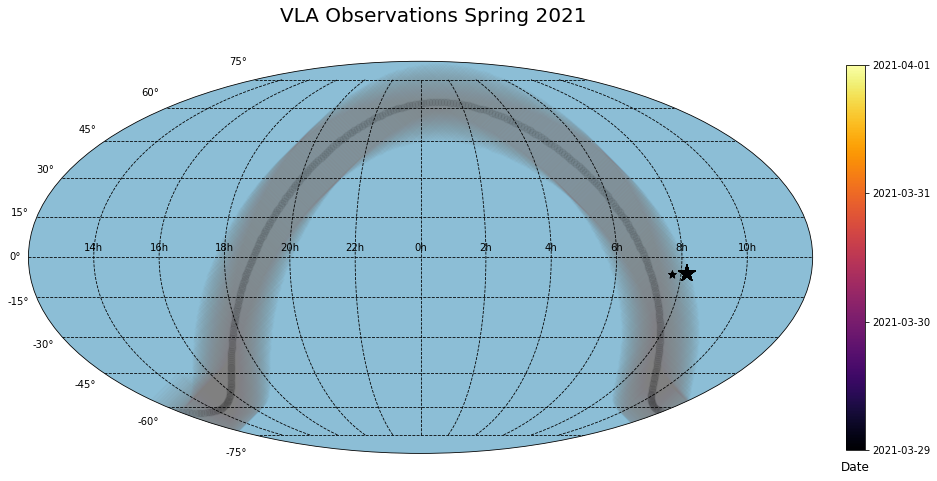

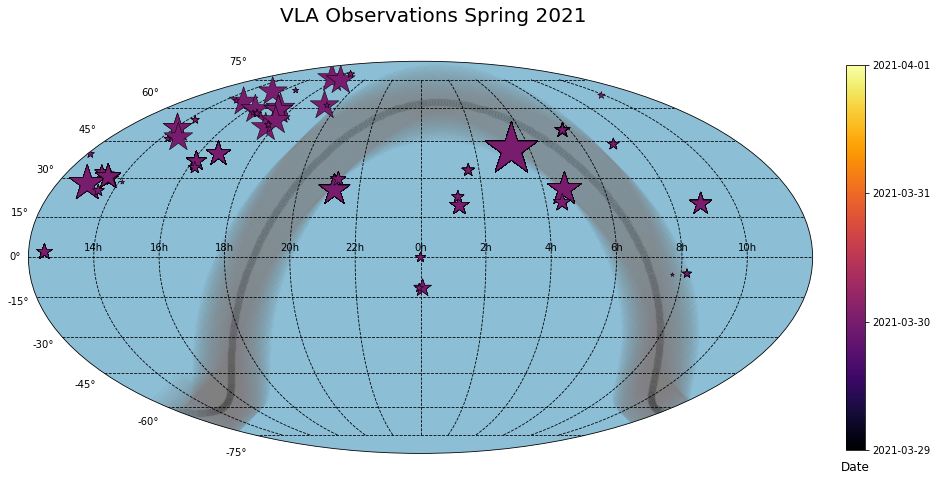

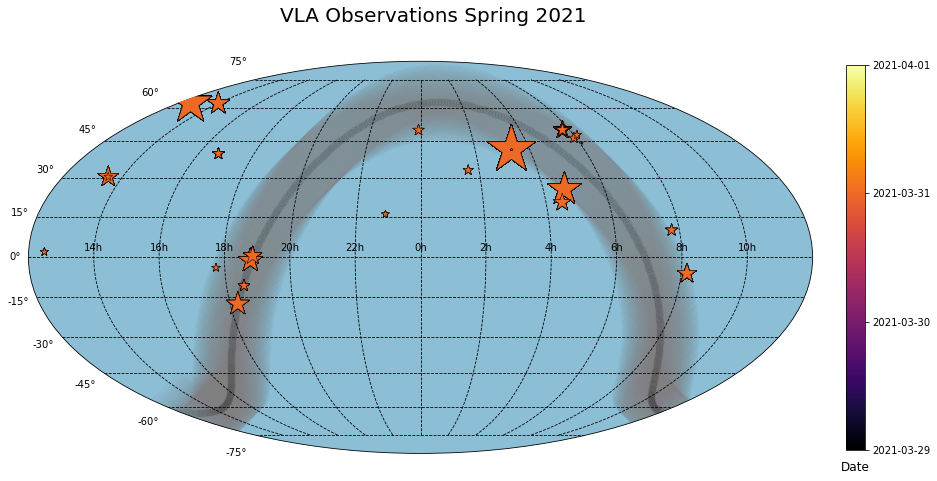

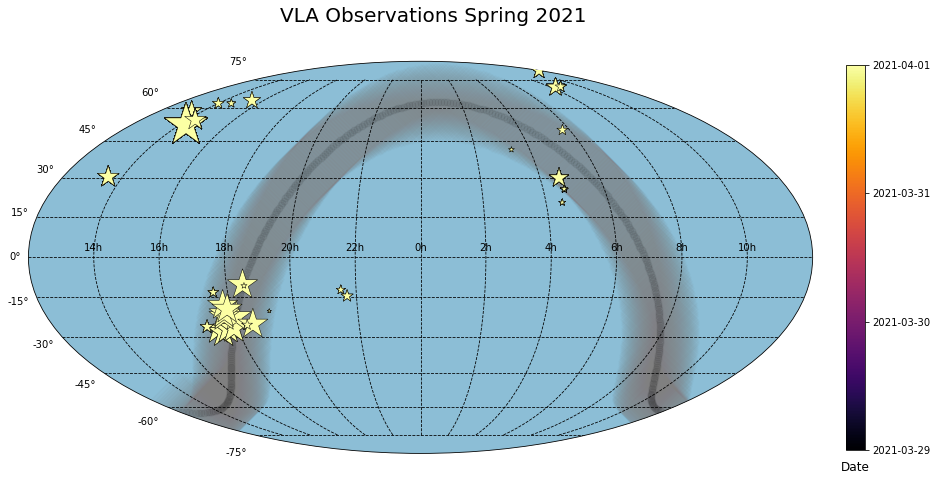

In [17]:
Dates = sorted(set(df.Start_Date))

import ephem
lon_array = np.arange(-180,180)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA = coord.Angle((eq_array[:,0]-180)*u.degree)
Dec = coord.Angle(-eq_array[:,1]*u.degree)

for d,date in enumerate(Dates):
    df_temp = df[df.Start_Date==date]
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection="mollweide")
    cmap=plt.cm.inferno
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(Dates))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    colors=cmap(norm(np.linspace(0,len(Dates),len(Dates))))
    ra = coord.Angle(df[df['Start_Date'].str.contains(date)]['RA']*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(df[df['Start_Date'].str.contains(date)]['DEC']*u.degree)
    targets = df[df['Start_Date'].str.contains(date)]['SRC']
    sizes = df_temp.groupby('SRC')['Obs_Secs'].transform('sum')/5
    ax.scatter(ra.radian, dec.radian,s=sizes,marker='*',edgecolor='black',linewidth=0.5,color=colors[d],zorder=10)
    ax.scatter(RA.radian,Dec.radian, zorder=0.7,s=50,color='black',alpha=0.05)
    ax.scatter(RA.radian,Dec.radian, zorder=0.5,s=3000,color='gray',alpha=0.05,marker='D')
    ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
    cbar=fig.colorbar(sm,pad=0.04,fraction=0.023)
    cbar.set_ticks(np.linspace(0,len(Dates),len(Dates)))
    cbar.set_ticklabels(sorted(set(Dates)))
    cbar.ax.set_title('Date',y=-0.07)
    plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=1)
    ax.set_facecolor('#8CBED6')
    fig.suptitle('VLA Observations Spring 2021', fontsize=20, y=0.85)
    plt.show()

### Plot 4b: Targets on Sky by Duration

Same sky coordinates plot, but now the colors represent the total duration of scans for each source, and the size of each marker is the number of scans conducted on that target.

Again, the snaking smudged band in the middle of the plot is the plane of the Milky Way for reference.

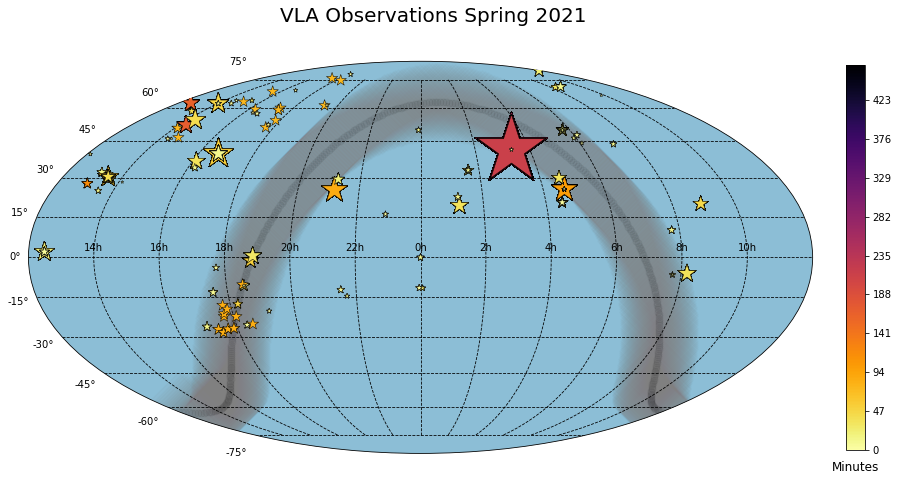

In [25]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection="mollweide")

Dates = sorted(set(df.Start_Date))
Duration = df.groupby('SRC')['Obs_Secs'].transform('sum')/60

import ephem
lon_array = np.arange(-180,180)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA = coord.Angle((eq_array[:,0]+random.random()-0.5-180)*u.degree)
Dec = coord.Angle((random.random()-0.5-eq_array[:,1])*u.degree)
ax.scatter(RA.radian,Dec.radian, zorder=0.7,s=50,color='black',alpha=0.04)
ax.scatter(RA.radian,Dec.radian, zorder=0.5,s=3000,color='gray',alpha=0.05,marker='D')

for d,date in enumerate(Dates):
    df_temp = df[df.Start_Date==date]
    dur = df_temp.groupby('SRC')['Obs_Secs'].transform('sum')/60
    cmap=plt.cm.inferno_r
    norm = matplotlib.colors.Normalize(vmin=0, vmax=max(Duration))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    colors=cmap(norm(dur))
    ra = coord.Angle(df[df['Start_Date'].str.contains(date)]['RA']*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(df[df['Start_Date'].str.contains(date)]['DEC']*u.degree)
    targets = df[df['Start_Date'].str.contains(date)]['SRC']
    sizes = [list(targets).count(i)*10 for i in targets]
    ax.scatter(ra.radian, dec.radian,s=sizes,marker='*',edgecolor='black',linewidth=0.5,color=colors,zorder=10)
    
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])

cbar=fig.colorbar(sm,pad=0.04,fraction=0.023)
cbar.set_ticks(np.arange(0,round(max(Duration)),round(max(Duration)/10)))
cbar.set_ticklabels(np.arange(0,round(max(Duration)),round(max(Duration)/10)))
cbar.ax.set_title('Minutes',y=-0.07)

plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=1)
ax.set_facecolor('#8CBED6')
fig.suptitle('VLA Observations Spring 2021', fontsize=20, y=0.85)
plt.show()

And again, I separated out each skymap by date.

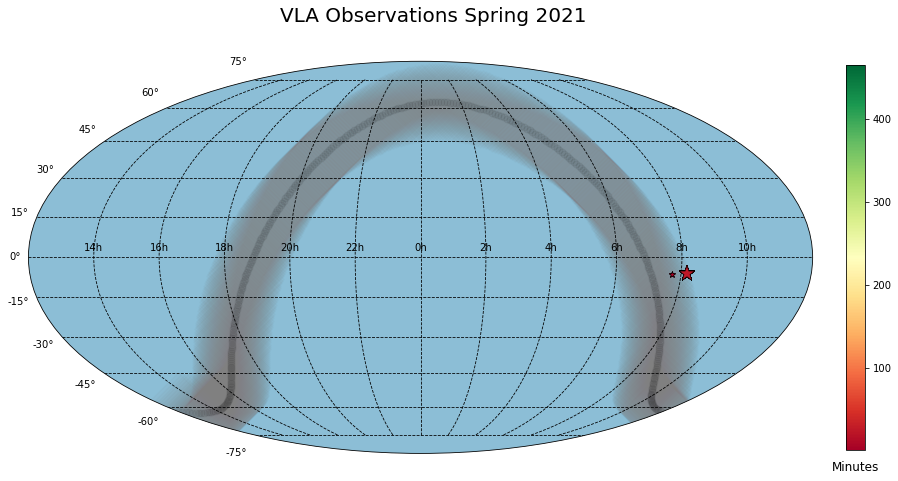

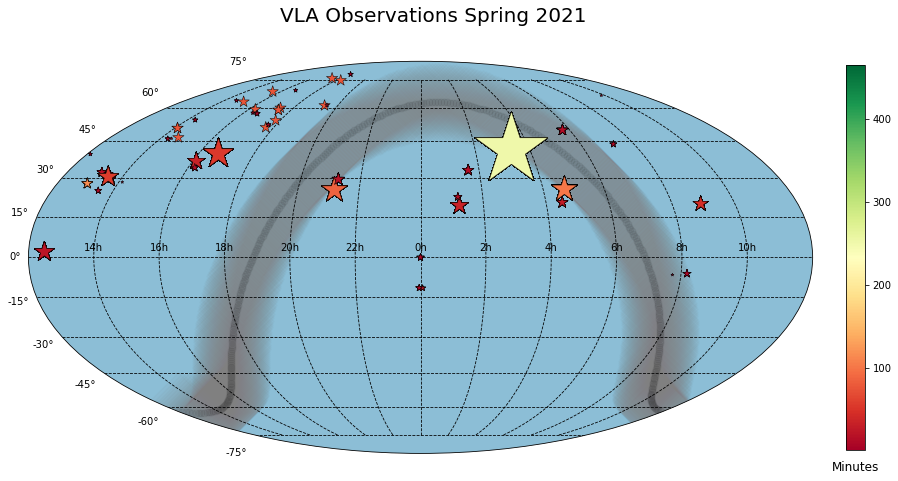

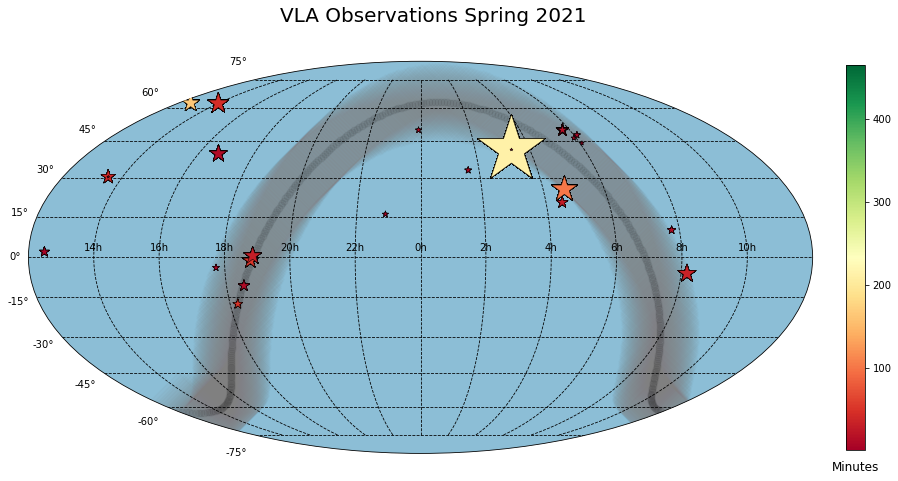

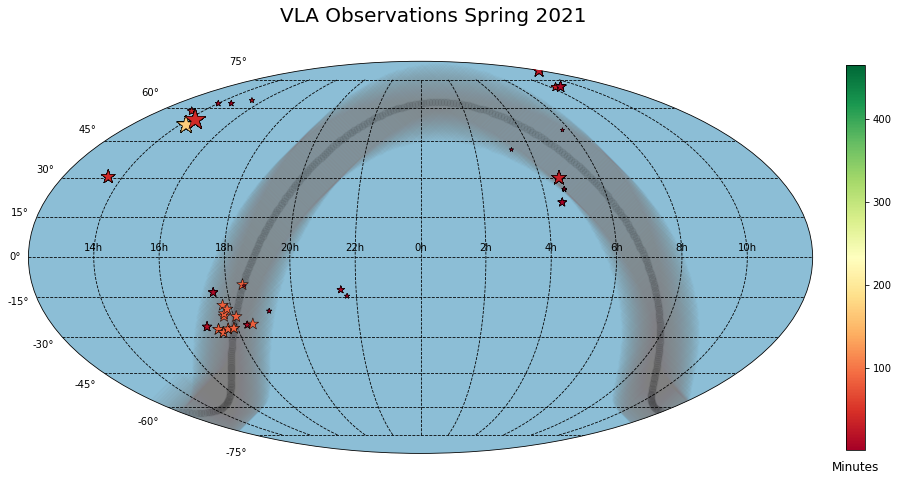

In [19]:
Dates = sorted(set(df.Start_Date))
Duration = df.groupby('SRC')['Obs_Secs'].transform('sum')/60

import ephem
lon_array = np.arange(-180,180)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA = coord.Angle((eq_array[:,0]-180)*u.degree)
Dec = coord.Angle(-eq_array[:,1]*u.degree)

cmap = plt.cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=min(Duration), vmax=max(Duration))

for d,date in enumerate(Dates):
    # Set colormapping
    df_temp = df[df.Start_Date==date]
    dur = df_temp.groupby('SRC')['Obs_Secs'].transform('sum')/60
    colors=cmap(norm(dur))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar=fig.colorbar(sm,pad=0.01)
    cbar.set_ticks(np.arange(0,round(max(Duration)),round(max(Duration)/10)))
    cbar.set_ticklabels(np.arange(0,round(max(Duration)),round(max(Duration)/10)))
    # Set skymap
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection="mollweide")
    # Set coordinates
    ra = coord.Angle(df[df['Start_Date'].str.contains(date)]['RA']*u.degree)
    ra = ra.wrap_at(180*u.degree)
    dec = coord.Angle(df[df['Start_Date'].str.contains(date)]['DEC']*u.degree)
    targets = df[df['Start_Date'].str.contains(date)]['SRC']
    sizes = [list(targets).count(i)*10 for i in targets]
    # Plot points
    ax.scatter(ra.radian, dec.radian,s=sizes,marker='*',edgecolor='black',linewidth=0.5,color=colors,zorder=10)
    ax.scatter(RA.radian,Dec.radian, zorder=0.7,s=50,color='black',alpha=0.05)
    ax.scatter(RA.radian,Dec.radian, zorder=0.5,s=3000,color='gray',alpha=0.05,marker='D')
    ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
    cbar=fig.colorbar(sm,pad=0.04,fraction=0.023)
    # Making it pretty
    plt.grid(axis='both', which='major', color='black', linestyle='--',zorder=1)
    ax.set_facecolor('#8CBED6')
    cbar.ax.set_title('Minutes',y=-0.07)
    fig.suptitle('VLA Observations Spring 2021', fontsize=20, y=0.85)
    plt.show()